# Pricing Worst-of Options
In this notebook we'll go over how to price European options using the analytic Black-Scholes-Merton solution and Monte Carlo simulation, before we transition to applying Monte Carlo techniques to worst-of options, where the payoff at maturity is the payoff of the lowest performing option, from a basket of options.


Please install all dependencies here or in your CLI:

In [ ]:
%pip install xgboost scikit-learn matplotlib pandas rich

## I. Generating Synthetic Data

To generate synthetic data, we'll use known empirical distributions of market statistics to create a representative market dataset. The [`generate_option_dataset`](data.py#L9) function creates a realistic dataset of option contracts with parameters that mirror observed market conditions:

* Stock prices generally follow a lognormal distribution
* Strike prices are generated relative to moneyness ratios, concentrated near at-the-money (ATM)
* Maturities follow standard cycles (weekly, monthly, and LEAPS)
* Volatility is modeled using a lognormal distribution
* Most stocks don't pay dividends, while those that do typically show a lognormal distribution of yield values
* Although risk-free rates aren't perfectly normal in reality, for simplicity we model them with a bounded normal distribution between 0-5%

The function provides precise control over all distribution parameters, enabling customization for specific market conditions or test scenarios. Default parameters reflect typical market conditions. The implementation includes several assertion checks that validate input parameters against realistic bounds, preventing the creation of datasets with implausible characteristics. For documentation and implementation details, refer to docstring in [`generate_option_dataset`](data.py#L9).



In [2]:
import numpy as np
import pandas as pd
from data import generate_option_dataset
from utils import display
from rich.console import Console

console = Console()
df = generate_option_dataset(seed=1995, n_samples=100)
display(df)

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ option_type           ┃ spot_price ┃ strike_price ┃ maturity ┃ risk_free_rate ┃ volatility ┃ dividend_yield ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ call                  │ 68.9410    │ 60.3014      │ 0.0192   │ 0.0317         │ 0.1746     │ 0.0115         │
│ call                  │ 99.5079    │ 87.4008      │ 0.7397   │ 0.0329         │ 0.2433     │ 0.0338         │
│ call                  │ 65.2847    │ 61.7066      │ 0.0384   │ 0.0444         │ 0.2202     │ 0.0239         │
│ put                   │ 46.9620    │ 52.8427      │ 0.0192   │ 0.0337         │ 0.5394     │ 0.0000         │
│ put                   │ 206.5615   │ 154.5294     │ 1.8027   │ 0.0345         │ 0.3630     │ 0.0235         │
│ Showing 5 of 100 rows │            │              │          │                │            │                │
└───────────────────────┴────────────┴──────────────┴──────────┴────────────────┴────────────┴────────────────┘

### The Black-Scholes-Merton Model
The [Black-Scholes-Merton (BSM)](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_equation) model describes the dynamics of European-style options through the partial differential equation (PDE):

$$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + (r-q)S\frac{\partial V}{\partial S} - rV = 0$$

The BSM model operates under the following assumptions:

* The underlying asset follows a Geometric Brownian Motion (GBM)
* No arbitrage opportunities exist
* Trading occurs continuously with no transaction costs
* The risk-free interest rate, dividend yield, and volatility parameters remain constant in time
* Options can only be exercised at expiration (European-style)

For a European option with current underlying price $S$, strike price $K$, time to maturity $T$, risk-free rate $r$, volatility $\sigma$, and dividend yield $q$, the analytical solutions are:
$$
\begin{align*}
C &= Se^{-qT}\Phi(d_1) - Ke^{-rT}\Phi(d_2) \tag{Call} \\
P &= Ke^{-rT}\Phi(-d_2) - Se^{-qT}\Phi(-d_1) \tag{Put}
\end{align*}
$$
where:
$$
\begin{align*}
d_1 &= \frac{\ln\left(\frac{S}{K}\right) + (r - q + \frac{\sigma^2}{2})T}{\sigma\sqrt{T}} \\
d_2 &= d_1 - \sigma\sqrt{T}
\end{align*}
$$
and $\Phi(\cdot)$ denotes the cumulative distribution function of the standard normal distribution. 
#### Implementation
The code for the implementation is contained in [`black_scholes.py`](black_scholes.py). This includes the [`black_scholes_price`](black_scholes.py#L84) function which applies the above formulation, using NumPy and SciPy's `norm.cdf()` to calculate the standard normal CDF values. The function [`get_bs_prices`](black_scholes.py#L4) uses [`black_scholes_price`](black_scholes.py#L84) to update a DataFrame containing multiple European option contracts. For more information, please consult the relevant docstrings of each function.

In [3]:
from black_scholes import get_bs_prices

# Compute BSM prices for each contract
df = get_bs_prices(df)

# Display DataFrame
display(df)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ option_type    ┃ spot_price ┃ strike_price ┃ maturity ┃ risk_free_rate ┃ volatility ┃ dividend_yield ┃ bs_price ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ call           │ 68.9410    │ 60.3014      │ 0.0192   │ 0.0317         │ 0.1746     │ 0.0115         │ 8.6611   │
│ call           │ 99.5079    │ 87.4008      │ 0.7397   │ 0.0329         │ 0.2433     │ 0.0338         │ 14.8665  │
│ call           │ 65.2847    │ 61.7066      │ 0.0384   │ 0.0444         │ 0.2202     │ 0.0239         │ 3.7412   │
│ put            │ 46.9620    │ 52.8427      │ 0.0192   │ 0.0337         │ 0.5394     │ 0.0000         │ 5.9392   │
│ put            │ 206.5615   │ 154.5294     │ 1.8027   │ 0.0345         │ 0.3630     │ 0.0235         │ 12.9229  │
│ Showing 5 of   │            │              │          │                │            │                │          │
│ 100 rows       │            │              │          │                │            │                │          │
└────────────────┴────────────┴──────────────┴──────────┴────────────────┴────────────┴────────────────┴──────────┘

### Monte Carlo Simulation

Following the formulation of BSM, we model the underlying $S_t$ as [geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion), which follows the stochastic differential equation (SDE):
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$
where $\mu, \sigma \in \R$ are the drift and volatility parameters, respectively, and $W_t$ is [standard Brownian motion](https://en.wikipedia.org/wiki/Wiener_process). The terminal solution to this SDE gives us the stock price at time $T$ as:

$$S_T = S_0 \exp\left(\left(\mu - \frac{\sigma^{2}}{2}\right)T + \sigma \sqrt{T} Z\right)$$

where $Z \sim \mathcal{N}(0, 1)$ is a standard normal random variable. This closed-form solution allows us to directly simulate terminal prices without discretizing the entire path, which is particularly efficient for pricing European options that depend only on the terminal value. For risk-neutral pricing, we replace the real-world drift $\mu$ with the risk-adjusted drift $(r - q - \frac{\sigma^{2}}{2})$, where $r$ is the risk-free rate and $q$ is the dividend yield, ensuring prices grow at the risk-free rate.

The Monte Carlo approach then:
1. Generates $n$ random samples of $S_T$ using the terminal solution
2. Calculates option payoffs for each sample (e.g., $\max(S_T - K, 0)$ for calls)
3. Discounts these payoffs at the risk-free rate: $e^{-rT}$
4. Estimates the option price as the average of these discounted payoffs

The code for the implementation can be found in [`monte_carlo.py`](monte_carlo.py). This includes the direct terminal simulation in the [`generate_paths`](monte_carlo.py#L6), while [`monte_carlo_price`](monte_carlo.py#L79) uses the terminal value to compute the option price, and [`get_mc_prices`](monte_carlo.py#L209) updates the DataFrame of option contracts to include all Monte Carlo prices. For more information, please see the relevant docstrings.

In [4]:
from monte_carlo import get_mc_prices

# Grab MC prices
df = get_mc_prices(df, num_samples=1000)

# Display the DataFrame
display(df)

┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ option_… ┃ spot_p… ┃ strike_… ┃ maturi… ┃ risk_fr… ┃ volati… ┃ dividen… ┃ bs_pri… ┃ mc_price ┃ mc_se  ┃ mc_com… ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ call     │ 68.9410 │ 60.3014  │ 0.0192  │ 0.0317   │ 0.1746  │ 0.0115   │ 8.6611  │ 8.6925   │ 0.0517 │ 0.0000  │
│ call     │ 99.5079 │ 87.4008  │ 0.7397  │ 0.0329   │ 0.2433  │ 0.0338   │ 14.8665 │ 14.8660  │ 0.5270 │ 0.0000  │
│ call     │ 65.2847 │ 61.7066  │ 0.0384  │ 0.0444   │ 0.2202  │ 0.0239   │ 3.7412  │ 3.7179   │ 0.0829 │ 0.0005  │
│ put      │ 46.9620 │ 52.8427  │ 0.0192  │ 0.0337   │ 0.5394  │ 0.0000   │ 5.9392  │ 6.0362   │ 0.1041 │ 0.0000  │
│ put      │ 206.56… │ 154.5294 │ 1.8027  │ 0.0345   │ 0.3630  │ 0.0235   │ 12.9229 │ 13.3534  │ 0.7495 │ 0.0005  │
│ Showing  │         │          │         │          │         │          │         │          │        │         │
│ 5 of 100 │         │          │         │          │         │          │         │          │        │         │
│ rows     │         │          │         │          │         │          │         │          │        │         │
└──────────┴─────────┴──────────┴─────────┴──────────┴─────────┴──────────┴─────────┴──────────┴────────┴─────────┘

We can examine how close our MC (numerical) price is to actual BS (analytical) price with the following:

In [5]:
from utils import compute_pricing_error
error = compute_pricing_error(df)
print(f"RMSE: {error:.4f}")

RMSE: 0.3724


#### Increasing the Number of Samples
A simple method to decrease the average MC pricing error is to increase the number of paths to simulate (corresponding to the `num_samples` parameter):

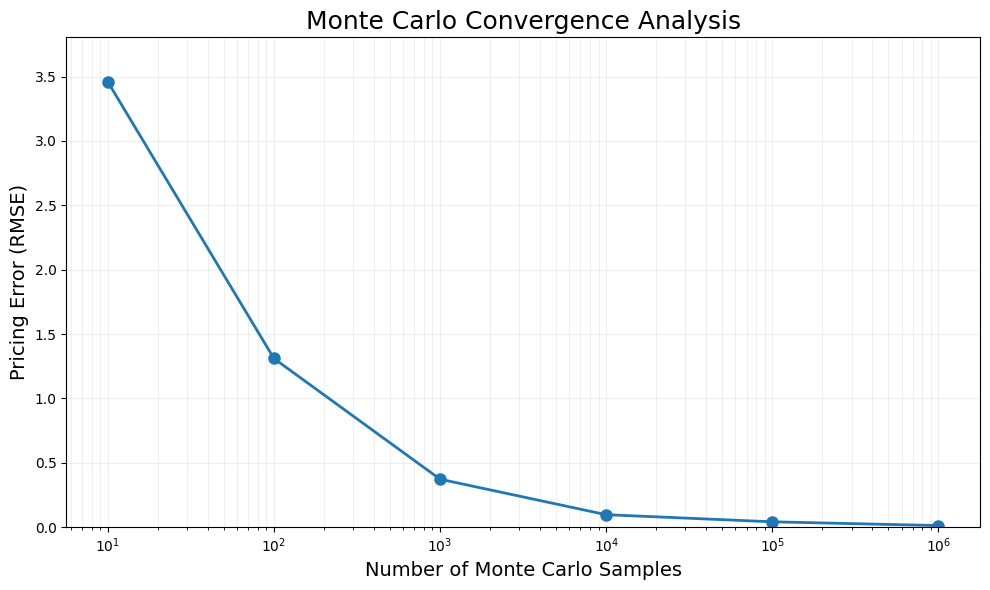

In [6]:
import matplotlib.pyplot as plt

sample_range = [10, 100, 1000, 10000, 100000, 1000000]
errors = []
# Compute pricing errors
for num_samples in sample_range:
    # Grab MC prices
    df = get_mc_prices(df, num_samples=num_samples)
    errors.append(
        compute_pricing_error(df)
    )
 
# Plot the results (log x-axis, linear y-axis)
plt.figure(figsize=(10, 6))
plt.semilogx(sample_range, errors, "o-", linewidth=2, markersize=8)
plt.xlabel("Number of Monte Carlo Samples", fontsize=14)
plt.ylabel("Pricing Error (RMSE)", fontsize=14)
plt.title("Monte Carlo Convergence Analysis", fontsize=18)
plt.grid(True, which="both", ls="-", alpha=0.2)

# Set y-axis from 0-100%
plt.ylim(0, min(100, max(errors)*1.1))

plt.tight_layout()
plt.show()

Examining the graph above, we observe a clear decrease in the percentage error relative to our Black-Scholes benchmark as the number of Monte Carlo samples increases.

#### Antithetic Sampling
While increasing the sample count is effective, it fundamentally does not change the underlying sampling process and comes at the cost of additional computation. We can further decrease error through variance reduction techniques such as antithetic sampling, which provides additional error reduction without increasing computational cost.

Antithetic sampling works by generating pairs of negatively correlated random variables. For each standard normal random variable $Z \sim \mathcal{N}(0,1)$, we also use its negative counterpart $-Z$. This creates two stock price paths:
$$S_T^+ = S_0 \exp\left(\left(\mu - \frac{\sigma^{2}}{2}\right)T + \sigma \sqrt{T} Z\right)$$
$$S_T^- = S_0 \exp\left(\left(\mu - \frac{\sigma^{2}}{2}\right)T - \sigma \sqrt{T} Z\right)$$

Since $\text{Cov}(Z, -Z) = -\text{Var}(Z) = -1$, the resulting option payoffs will be negatively correlated. This effectively creates a more balanced exploration of the probability space without requiring additional random samples. To apply antithetic sampling, we can set the argument `antithetic=True` in [`get_mc_prices`](monte_carlo.py#L200).

#### Control Variates
Another powerful variance reduction technique is the control variate method, which one can think of as a form of "intelligent outlier control" for our Monte Carlo paths. We use the terminal stock price $S_T$ as a control variate since its expected value under risk-neutral pricing is known to be $\mathbb{E}[S_T] = S_0e^{(r-q)T}$. When simulated paths deviate from this theoretical value, we apply a correction to the option payoff:

$$\hat{f}(S_T) = f(S_T) - \beta(\underbrace{S_T - \mathbb{E}[S_T]}_{\text{Price deviation}})$$

The optimal coefficient $\beta$ is given by:

$$\beta = \frac{\text{Cov}(f(S_T), S_T)}{\text{Var}(S_T)}$$

which minimizes the variance of our estimator $\hat{f}(S_T)$. Intuitively, if our simulation randomly produces stock prices higher than theory predicts, we adjust our option payoffs downward to compensate, and vice versa. This creates a stabilizing effect that pulls extreme paths closer to their theoretical values without introducing bias, making our Monte Carlo estimates converge faster to the true option price. To enable control variates in our pricing model, we can set `control_variate=True` in [`get_mc_prices`](monte_carlo.py#L200).

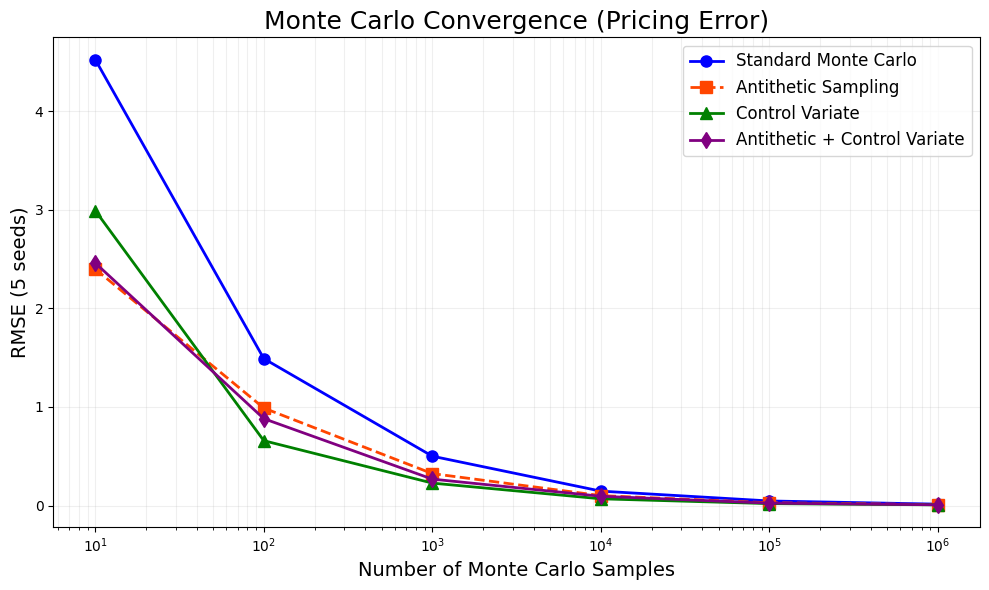

In [7]:
# Standard Monte Carlo errors
seeds = [37, 2, 99, 859, 71]
num_option_samples = 100
std_errors = []
std_error_stddevs = []

for num_samples in sample_range:
    seed_errors = []
    for seed in seeds:
        # Grab MC prices
        df = generate_option_dataset(seed=seed, n_samples=num_option_samples)
        df = get_bs_prices(df)
        df = get_mc_prices(df, num_samples=num_samples, seed=seed)
        seed_errors.append(
            compute_pricing_error(df)
        )
    std_errors.append(sum(seed_errors) / len(seeds))
    std_error_stddevs.append(np.std(seed_errors, ddof=1))
        
# Antithetic sampling errors
at_errors = []
at_error_stddevs = []

for num_samples in sample_range:
    seed_errors = []
    for seed in seeds:
        # Grab MC prices
        df = generate_option_dataset(seed=seed, n_samples=num_option_samples)
        df = get_bs_prices(df)
        df = get_mc_prices(df, num_samples=num_samples, antithetic=True, seed=seed)
        seed_errors.append(
            compute_pricing_error(df)
        )
    at_errors.append(sum(seed_errors) / len(seeds))
    at_error_stddevs.append(np.std(seed_errors, ddof=1))
    
# Control variate errors
cv_errors = []
cv_error_stddevs = []

for num_samples in sample_range:
    seed_errors = []
    for seed in seeds:
        # Grab MC prices
        df = generate_option_dataset(seed=seed, n_samples=num_option_samples)
        df = get_bs_prices(df)
        df = get_mc_prices(df, num_samples=num_samples, control_variate=True, seed=seed)
        seed_errors.append(
            compute_pricing_error(df)
        )
    cv_errors.append(sum(seed_errors) / len(seeds))
    cv_error_stddevs.append(np.std(seed_errors, ddof=1))

# Combined control variate + antithetic errors
combined_errors = []
combined_error_stddevs = []

for num_samples in sample_range:
    seed_errors = []
    for seed in seeds:
        # Grab MC prices
        df = generate_option_dataset(seed=seed, n_samples=num_option_samples)
        df = get_bs_prices(df)
        df = get_mc_prices(df, num_samples=num_samples, control_variate=True, antithetic=True, seed=seed) 
        seed_errors.append(
            compute_pricing_error(df)
        )
    combined_errors.append(sum(seed_errors) / len(seeds))
    combined_error_stddevs.append(np.std(seed_errors, ddof=1))

# Plotting mean errors
plt.figure(figsize=(10, 6))
plt.semilogx(sample_range, std_errors, "o-", linewidth=2, markersize=8, 
             label="Standard Monte Carlo", color="blue")
plt.semilogx(sample_range, at_errors, "s--", linewidth=2, markersize=8, 
             color="orangered", label="Antithetic Sampling")
plt.semilogx(sample_range, cv_errors, "^-", linewidth=2, markersize=8, 
             color="green", label="Control Variate")
plt.semilogx(sample_range, combined_errors, "d-", linewidth=2, markersize=8, 
             color="purple", label="Antithetic + Control Variate")
plt.xlabel("Number of Monte Carlo Samples", fontsize=14)
plt.ylabel("RMSE (5 seeds)", fontsize=14)
plt.title("Monte Carlo Convergence (Pricing Error)", fontsize=18)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

The graph illustrates the convergence behavior of different Monte Carlo methods for option pricing, comparing the Root Mean Square Error (RMSE) against the number of Monte Carlo samples used. At low sample counts (around 10), standard Monte Carlo shows the highest error (approximately 4.5), while variance reduction techniques such as (control variates and antithetic sampling) demonstrate significantly lower initial errors. As the number of samples increases ($10^3$ to $10^6$), all methods converge to near-zero error, with the variance reduction techniques consistently outperforming standard Monte Carlo until about $10^5$ samples, where the differences become negligible.

It"s also important to analyze the variability of pricing errors (as shown below) because lower standard deviation indicates more consistent and reliable pricing outcomes. This helps quantify model stability across different market conditions and provides greater confidence in the pricing results, even if the average error remains the same.

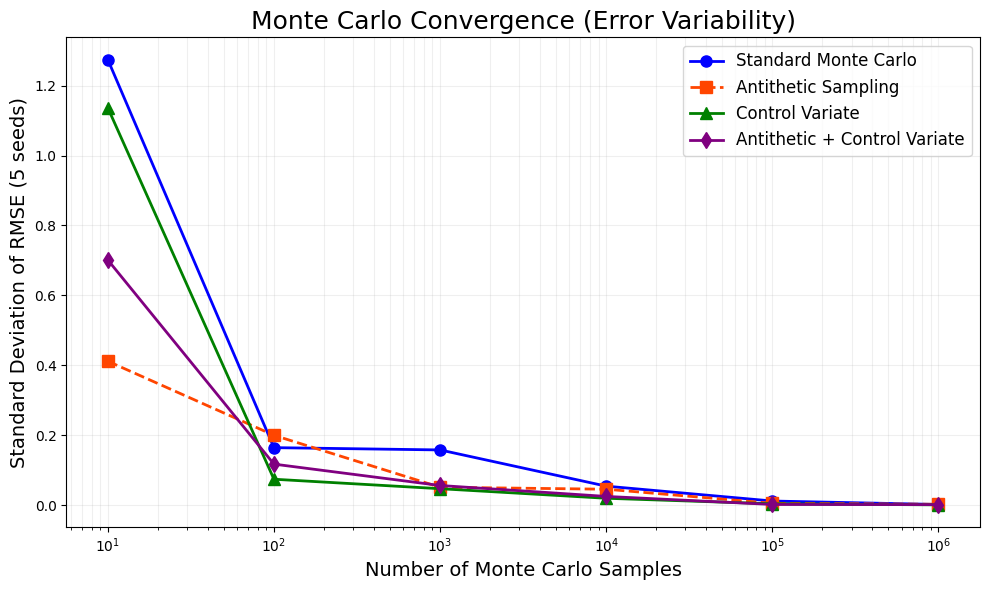

In [8]:
# Second plot - Standard deviations
plt.figure(figsize=(10, 6))
plt.semilogx(sample_range, std_error_stddevs, "o-", linewidth=2, markersize=8, 
             label="Standard Monte Carlo", color="blue")
plt.semilogx(sample_range, at_error_stddevs, "s--", linewidth=2, markersize=8, 
             color="orangered", label="Antithetic Sampling")
plt.semilogx(sample_range, cv_error_stddevs, "^-", linewidth=2, markersize=8, 
             color="green", label="Control Variate")
plt.semilogx(sample_range, combined_error_stddevs, "d-", linewidth=2, markersize=8, 
             color="purple", label="Antithetic + Control Variate")
plt.xlabel("Number of Monte Carlo Samples", fontsize=14)
plt.ylabel("Standard Deviation of RMSE (5 seeds)", fontsize=14)
plt.title("Monte Carlo Convergence (Error Variability)", fontsize=18)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

This graph above shows the standard deviation of Root Mean Square Error (RMSE) across five different random seeds as a function of the number of samples, for various Monte Carlo option pricing methods. Antithetic sampling (orange) demonstrates remarkably low variability even at small sample sizes (10), starting with approximately 0.4 standard deviation compared to standard Monte Carlo's 1.25. As the number of samples increases beyond 100, the control variate method (green) and the combined approach (purple) show the most consistent results with minimal variability. All methods converge to near-zero standard deviation at higher sample counts ($10^5-10^6$).

In [9]:
# Create DataFrame with methods as rows and sample sizes as columns
error_df = pd.DataFrame(
    index=["Standard MC", "Antithetic", "Control Variate", "Antithetic + Control Variate"],
    columns=sample_range
)

# Fill with your computed error values
error_df.loc["Standard MC"] = std_errors
error_df.loc["Antithetic"] = at_errors
error_df.loc["Control Variate"] = cv_errors
error_df.loc["Antithetic + Control Variate"] = combined_errors

# Rename columns and index for clarity
error_df.columns.name = "Number of Samples"
error_df.index.name = "Method"

In [10]:
highlight_map = {size: {'min': 'green'} for size in sample_range}
display(error_df, highlight_map=highlight_map, show_index=True)
winner = max(error_df.index, key=lambda method: sum(1 for size in sample_range if error_df.loc[method, size] == error_df[size].min()))
console.print(f"The best performing method Monte Carlo method is: [green]{winner}[/green]!")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Method                       ┃ 10     ┃ 100    ┃ 1000   ┃ 10000  ┃ 100000 ┃ 1000000 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ Standard MC                  │ 4.5214 │ 1.4895 │ 0.5004 │ 0.1460 │ 0.0463 │ 0.0141  │
│ Antithetic                   │ 2.3977 │ 0.9883 │ 0.3237 │ 0.1006 │ 0.0280 │ 0.0094  │
│ Control Variate              │ 2.9903 │ 0.6575 │ 0.2275 │ 0.0681 │ 0.0194 │ 0.0068  │
│ Antithetic + Control Variate │ 2.4587 │ 0.8808 │ 0.2677 │ 0.0940 │ 0.0241 │ 0.0074  │
└──────────────────────────────┴────────┴────────┴────────┴────────┴────────┴─────────┘

The best performing method Monte Carlo method is: Control Variate!

## II. Building the ML Model
### Featurization
The script [`features.py`](features.py) contains the [`get_features`](features.py) function which transforms option contract parameters into useful features for machine learning. This includes:
* `is_call`: A binary indicator for call options (1=call, 0=put)
* `moneyness`: The ratio of spot price to strike price (S/K)
* `log_moneyness`: Natural log of moneyness
* `time_sqrt`: Square root of time to maturity; reflects how uncertainty grows with the square root of time rather than linearly
* `vol_time`: Volatility × square root of time; represents the expected price movement range over the option's lifetime
* `carry_cost`: Cost of carry (r-q); measures the net financing cost of holding the underlying asset versus the option
* `intrinsic_value`: Intrinsic value of the option (what you would get by exercising immediately)
* `is_itm`: Binary indicator if option is in-the-money (1=ITM, 0=OTM)
* `moneyness_vol`: Interaction between moneyness and volatility; helps capture the "volatility smile" effect seen in options markets
* `moneyness_time`: Interaction between moneyness and time; models how time value changes differently based on distance from strike price
* `vol_squared`: Squared volatility term for capturing non-linear effects
* `carry_time`: Interaction between carry cost and time; represents the compounding effect of interest rates and dividends over time


In [11]:
from features import get_features
from data import generate_option_dataset
from black_scholes import get_bs_prices
from monte_carlo import get_mc_prices
import pandas as pd
import numpy as np
from utils import display

df = generate_option_dataset(seed=1995, n_samples=1000)
df = get_bs_prices(df)
df = get_mc_prices(df)
df = get_features(df)

Now let's split the dataset into the training, validation, and test sets:

In [12]:
from sklearn.model_selection import train_test_split

Y = df["bs_price"]
X = df.drop(
    ["option_type",
    "bs_price",
    "mc_price", 
    "mc_se",
    "mc_compute_time"],
    axis=1
)

X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(f"Train inputs: {X_train.shape}. Train targets: {y_train.shape}")
print(f"Validation inputs: {X_val.shape}. Validation targets: {y_val.shape}")
print(f"Test inputs: {X_test.shape}. Test targets: {y_test.shape}")

Train inputs: (640, 18). Train targets: (640,)
Validation inputs: (160, 18). Validation targets: (160,)
Test inputs: (200, 18). Test targets: (200,)


Before applying normalization, find the list of numerical features to include normalization (some variables like `is_atm` should not be normalized as they are binary indicators):

In [13]:
# Binary features
non_numerical_features = ["is_call", "is_itm"]

# Get numerical features by set difference
all_columns = X_train.columns.tolist()
numerical_features = list(set(all_columns) - set(non_numerical_features))
features_df = pd.DataFrame(numerical_features, columns=["Numerical Features"])
display(df=features_df, num_rows=len(numerical_features))

┏━━━━━━━━━━━━━━━━━━━━┓
┃ Numerical Features ┃
┡━━━━━━━━━━━━━━━━━━━━┩
│ carry_cost         │
│ risk_free_rate     │
│ strike_price       │
│ vol_squared        │
│ intrinsic_value    │
│ vol_time           │
│ carry_time         │
│ moneyness_vol      │
│ volatility         │
│ maturity           │
│ moneyness_time     │
│ moneyness          │
│ dividend_yield     │
│ log_moneyness      │
│ time_sqrt          │
│ spot_price         │
└────────────────────┘

We apply normalization to each numerical feature with scikit-learn's built-in `StandardScaler` by fitting on the training data (to prevent data leakage), and transforming the training, validation, and test sets:

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

Now our data is ready to be trained on and processed by the XGBoost model.

Training final model with best parameters...


<Figure size 1000x600 with 0 Axes>

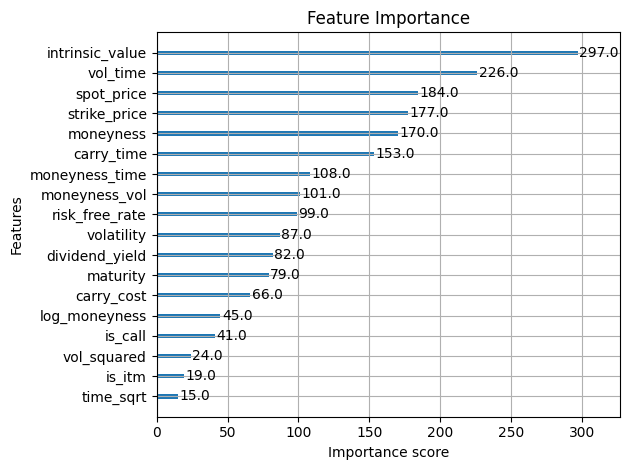

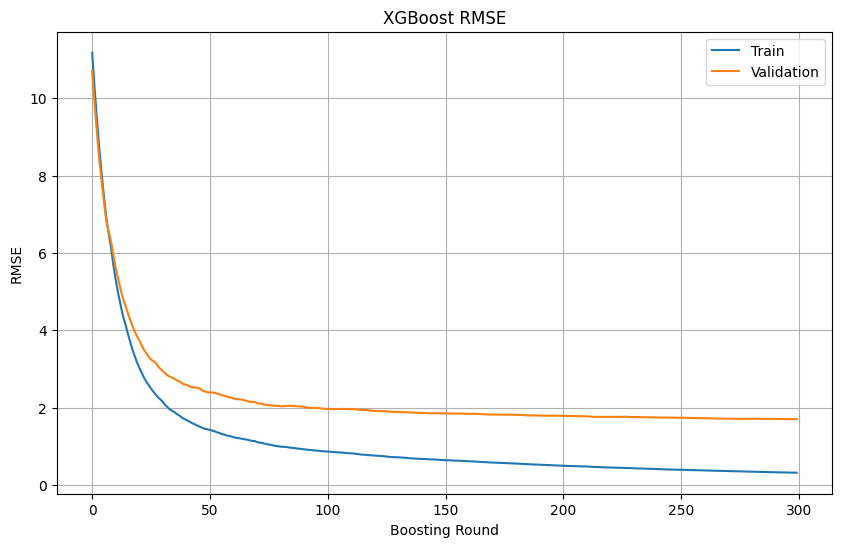

[22:26:46] Test set metrics:                                                                       ]8;id=180090;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\2727255917.py\2727255917.py]8;;\:]8;id=609642;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\2727255917.py#38\38]8;;\

┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ mse    ┃ rmse   ┃ mae    ┃ r2     ┃ wmape   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ 5.1087 │ 2.2602 │ 1.1001 │ 0.9703 │ 11.8217 │
└────────┴────────┴────────┴────────┴─────────┘

In [15]:
from models import tune_model, train_best_model, evaluate

param_grid = {
    "max_depth": [3, 6, 9],           # Maximum depth of each tree
    "learning_rate": [0.01, 0.05, 0.1], # Step size for gradient descent
    "n_estimators": [100, 200, 300],   # Number of trees
    "subsample": [0.8, 1.0],           # Fraction of samples per tree
    "colsample_bytree": [0.8, 1.0]     # Fraction of features per tree
}

# Hyperparameter tuning
best_model, best_params = tune_model(
    X_train,
    y_train,
    param_grid=param_grid,
    n_iter=100,
)

# After finding the best model, train it again using direct API from XGBoost
final_model, evals_result = train_best_model(
    X_train,
    y_train,
    X_val,
    y_val,
    best_params,
    early_stopping_rounds=50,
)

# Evaluate best model
test_metrics = evaluate(
    final_model,
    X_test,
    y_test,
    evals_result,
    plot_results=True,
)

console.log(f"Test set metrics:")
display(test_metrics)

## III. European Worst-Of Option

### Monte Carlo Simulation for Correlated Assets

To simulate correlated asset terminal values, we can use a direct implementation of the GBM solution with Cholesky decomposition. Starting with uncorrelated standard normal variables $X^{(1)}, X^{(2)} \sim \mathcal{N}(0,1)$, we construct correlated random variables:

$$
\begin{align*}
   Z^{(1)} &= X^{(1)}, \\
   Z^{(2)} &= \rho X^{(1)} + \sqrt{1 - \rho^2}X^{(2)},
\end{align*}
$$

This transformation forces $\text{Corr}(Z^{(1)}, Z^{(2)}) = \rho$. Using these correlated variables, we directly simulate the terminal asset values at time $T$:

$$
\begin{align*}
   S^{(1)}_T &= S^{(1)}_{0} \exp\Big(\left(\mu^{(1)} - \frac{(\sigma^{(1)})^2}{2}\right)T + \sigma^{(1)} \sqrt{T} Z^{(1)}\Big), \\
   S^{(2)}_T &= S^{(2)}_{0} \exp\Big(\left(\mu^{(2)} - \frac{(\sigma^{(2)})^2}{2}\right)T + \sigma^{(2)} \sqrt{T} Z^{(2)}\Big).
\end{align*}
$$

This approach ensures that the log returns of both assets from initial to terminal time maintain correlation $\rho$:

$$\rho = \text{Corr}\left(\log\left( \frac{S^{(1)}_T}{S^{(1)}_{0}} \right), \log\left( \frac{S^{(2)}_T}{S^{(2)}_{0}} \right)\right) =  \text{Corr}\left(\log\left(\bar{S}_T^{(1)} \right), \log\left( \bar{S}_T^{(2)} \right)\right), $$

where:
$$
\begin{align}
   \bar{S}_T^{(1)} = \frac{S_T^{(1)}}{S_0^{(1)}}, \ \ \ \bar{S}_T^{(2)} = \frac{S_T^{(2)}}{S_0^{(2)}}.
\end{align}
$$
are the normalized maturity prices. By engineering correlation at the log-return level over the entire time horizon, we capture the fundamental relationship between asset movements in a single step, which is computationally more efficient than simulating the full path while maintaining consistency with financial theory.


#### Control Variates for worst-of Options
For basket options with worst-of payoffs, we can extend the control variate technique using an indicator-based approach that focuses on the asset determining the payoff. Since the option pays based on the worst-performing asset, we apply a selective control variate adjustment with:

$$\hat{f}(\mathbf{S}_T) = f(\mathbf{S}_T) - I(\mathbf{\bar{S}}_T) \cdot \beta_1({S_T^{(1)} - \mathbb{E}[S_T^{(1)}]}) - (1-I(\mathbf{\bar{S}}_T)) \cdot \beta_2(S_T^{(2)} - \mathbb{E}[S_T^{(2)}]),$$

where $\mathbf{S}_T = (S_T^{(1)}, S_T^{(2)})^T$ are the terminal values from Monte Carlo, and:
$$
\begin{align*}
   I(\mathbf{\bar{S}}_T) = \begin{cases} 
      1 &\text{if } \bar{S}_T^{(1)} \leq \bar{S}_T^{(2)} \\
      0 &\text{otherwise}
   \end{cases}
\end{align*}
$$
is an indicator function which is $1$ if asset 1 is the worst-performing asset, and 0 otherwise, with respect to the normalized maturity prices $\mathbf{\bar{S}}_T = (\bar{S}_T^{(1)}, \bar{S}_T^{(2)})^T$. The optimal coefficients are calculated conditionally:

$$\beta_1 = \frac{\text{Cov}(f(\mathbf{S}_T), S_T^{(1)} | S_T^{(1)} \leq S_T^{(2)})}{\text{Var}(S_T^{(1)} | S_T^{(1)} \leq S_T^{(2)})}, \quad \beta_2 = \frac{\text{Cov}(f(\mathbf{S}_T), S_T^{(2)} | S_T^{(2)} < S_T^{(1)})}{\text{Var}(S_T^{(2)} | S_T^{(2)} < S_T^{(1)})}$$

This approach targets the variance reduction specifically to the asset driving the payoff in each simulation path. The underlying asset correlation structure is implicitly captured through the Monte Carlo paths generated via Cholesky decomposition, without requiring explicit handling in the control variate implementation. This selective adjustment efficiently reduces variance in worst-of option pricing, particularly for options sensitive to the relative performance between the basket assets.

#### Implementation
The implementation is contained in [`worst_of_option.py`](worst_of_option.py), which follows a similar structure to [`monte_carlo.py`](monte_carlo.py). The key differences are:

1. The [`generate_correlated_paths`](worst_of_option.py#L6) function creates correlated asset paths for multi-asset options
2. The [`monte_carlo_worstof_option`](worst_of_option.py#L50)  function handles:
  - Calculating the nonlinear worst-of payoff
  - Implementing the custom control variate model
  - Computing the final option price

#### Limitations & Future Improvements

While this method effectively generalizes the approach and experiments confirm variance reduction, there are opportunities for enhancement. The control variate model faces challenges with discontinuities at boundaries where assets have similar performance, and the current formulation of $\hat{f}(\mathbf{S}_T)$ doesn't fully capture asset interaction effects.

These limitations occasionally affected the calculation of $\beta_1$ and $\beta_2$ coefficients, sometimes resulting in large values that could produce theoretically impossible negative payoffs, and negative option prices as a result. To address this, I implemented two stabilizing mechanisms in `monte_carlo_worstof_option`:

1. A `dampening_factor` parameter to scale the control variate correction (providing smaller corrections)
2. A `clip_payoffs` argument to ensure non-negative payoffs

These adjustments successfully balance variance reduction with pricing accuracy for most scenarios. Future enhancements could incorporate correlation coefficients $\rho$ and interaction terms directly into $\hat{f}(\mathbf{S}_T)$, potentially achieving even greater variance reduction while maintaining pricing integrity.


#### Dataset Generation
The `worst_of` flag in [`generate_option_dataset`](data.py) provides us a synthetic dataset of a basket of two option contracts, with all the relevant parameters we will need to model a worst-of option.

In [16]:
from data import generate_option_dataset
from utils import display

# Turn on worst_of=True to generate basket of two option contracts
df = generate_option_dataset(n_samples=1000, worst_of=True)
print(df.head())

  option_type  spot_price1  spot_price2  strike_performance  maturity  \
0        call   155.630809   134.940392            1.024966  1.487671   
1        call    80.276838   185.076012            1.300000  0.986301   
2        call    99.725916    94.311822            1.071357  0.019178   
3         put    98.412662    75.936399            0.930399  0.082192   
4         put    59.036616   214.078458            0.916796  0.019178   

   risk_free_rate  volatility1  volatility2  dividend_yield1  dividend_yield2  \
0        0.037928     0.203776     0.225516         0.012759         0.031776   
1        0.027298     0.167207     0.319861         0.027274         0.007953   
2        0.038967     0.365394     0.283938         0.000000         0.015452   
3        0.024230     0.296677     0.290086         0.008717         0.025080   
4        0.034236     0.320830     0.314484         0.013930         0.029138   

   correlation  
0     0.876520  
1     0.441191  
2     0.069107  
3    -

#### Monte Carlo Simulation (Control Variate vs. Standard)

Empirical testing shows that a `dampening_factor` of 0.005 provides optimal balance between variance reduction and numerical stability. This setting consistently produces valid non-negative payoffs while significantly reducing error variation compared to standard Monte Carlo methods. For these experiments, we've opted not to use `clip_payoffs=True` to maintain the natural characteristics of the simulation data and avoid potential unecessary distortion in our modeling.

In [17]:
from worst_of_option import get_worstof_mc_prices
import numpy as np
from rich.console import Console

# Get results from both methods
console = Console()
num_samples=10000
cv_df = get_worstof_mc_prices(
    df,
    num_samples=num_samples,
    control_variate=True,
    dampening_factor=0.005,
    clip_payoffs=False
)

regular_df = get_worstof_mc_prices(
    df,
    num_samples=num_samples,
    control_variate=False
)

# Filter nonzero values of Monte Carlo Standard Error
valid_mask = (cv_df["mc_se"] > 0) & (regular_df["mc_se"] > 0)
cv_var = cv_df.loc[valid_mask, "mc_se"].values ** 2
regular_var = regular_df.loc[valid_mask, "mc_se"].values ** 2

# Calculate variance reduction
variance_reduction = np.mean((1 - cv_var / regular_var) * 100)
console.log(f"Variance reduction (control variate): {variance_reduction:.4f}%")

# Check for negative option price values
num_negative_prices = (cv_df["mc_se"] < 0).sum()
console.log(f"Number of negative option prices: {num_negative_prices}")

[22:27:05] Variance reduction (control variate): 40.3254%                                          ]8;id=475990;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\2096192931.py\2096192931.py]8;;\:]8;id=786901;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\2096192931.py#29\29]8;;\

           Number of negative option prices: 0                                                     ]8;id=908448;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\2096192931.py\2096192931.py]8;;\:]8;id=818377;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\2096192931.py#33\33]8;;\

We'll implement our featurization pipeline similar to our implementation for a single plain vanilla European option, but with a few additional features. The `worst_of` flag provides features for this specific setting:

In [18]:
from features import get_features
df = get_features(cv_df, worst_of=True)

from sklearn.model_selection import train_test_split
import pandas as pd

Y = df["mc_price"]
X = df.drop(
    ["option_type",
    "mc_price",
    "mc_se",
    "mc_compute_time",
    "beta1",
    "beta2",
    "worst_is_S1_pct"],
    axis=1
)

X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(f"Train inputs: {X_train.shape}. Train targets: {y_train.shape}")
print(f"Validation inputs: {X_val.shape}. Validation targets: {y_val.shape}")
print(f"Test inputs: {X_test.shape}. Test targets: {y_test.shape}")

# Binary features
non_numerical_features = ["is_call"]

# Get numerical features by set difference
all_columns = X_train.columns.tolist()
numerical_features = list(set(all_columns) - set(non_numerical_features))
features_df = pd.DataFrame(numerical_features, columns=["Numerical Features"])
display(df=features_df, num_rows=len(numerical_features))

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

Train inputs: (640, 25). Train targets: (640,)
Validation inputs: (160, 25). Validation targets: (160,)
Test inputs: (200, 25). Test targets: (200,)


┏━━━━━━━━━━━━━━━━━━━━┓
┃ Numerical Features ┃
┡━━━━━━━━━━━━━━━━━━━━┩
│ dividend_yield1    │
│ volatility2        │
│ volatility1        │
│ carry_cost1        │
│ moneyness_vol1     │
│ carry_time2        │
│ correlation        │
│ vol_time1          │
│ risk_free_rate     │
│ strike_performance │
│ vol_squared1       │
│ carry_cost2        │
│ moneyness_vol2     │
│ carry_time1        │
│ vol_squared2       │
│ maturity           │
│ dividend_yield2    │
│ moneyness_time     │
│ moneyness          │
│ log_moneyness      │
│ time_sqrt          │
│ spot_price2        │
│ vol_time2          │
│ spot_price1        │
└────────────────────┘

Then we can use our XGBoost pipeline from earlier to predict MC prices:

Training final model with best parameters...


<Figure size 1000x600 with 0 Axes>

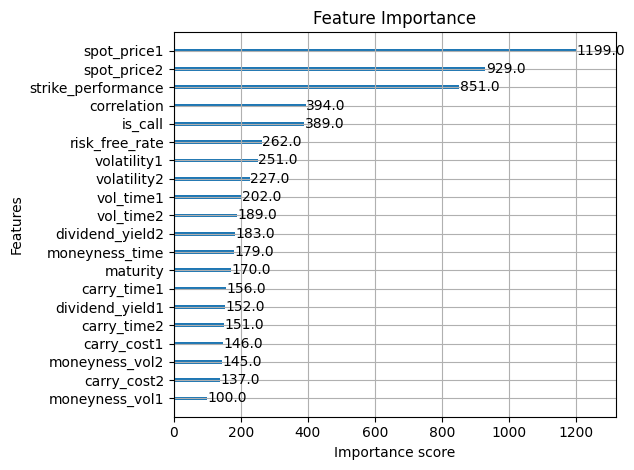

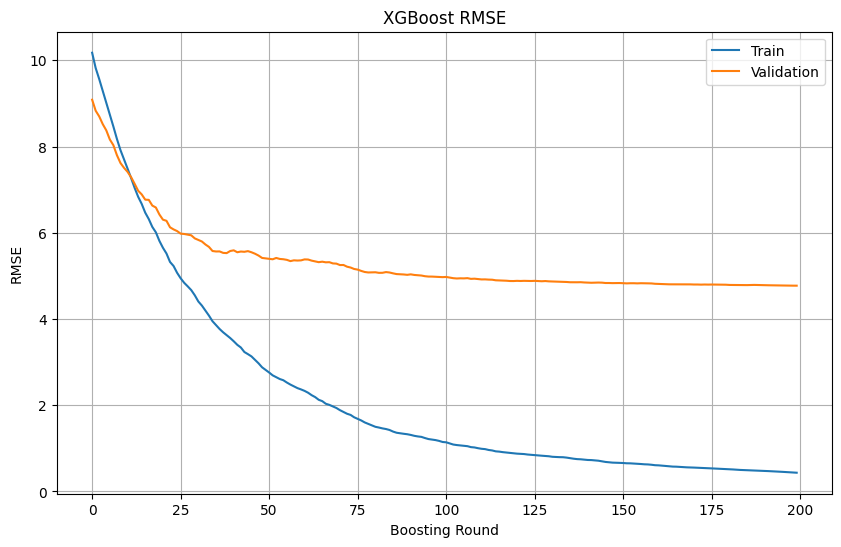

[22:27:58] Test set metrics:                                                                       ]8;id=123037;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\1413256661.py\1413256661.py]8;;\:]8;id=919058;file://C:\Users\xmoot\AppData\Local\Temp\ipykernel_15168\1413256661.py#37\37]8;;\

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ mse     ┃ rmse   ┃ mae    ┃ r2     ┃ wmape   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ 16.9768 │ 4.1203 │ 2.6220 │ 0.8203 │ 32.6612 │
└─────────┴────────┴────────┴────────┴─────────┘

In [19]:
from models import tune_model, train_best_model, evaluate
from rich.console import Console

console = Console()
param_grid = {
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

best_model, best_params = tune_model(
    X_train,
    y_train,
    param_grid=param_grid,
    n_iter=100,
)

final_model, evals_result = train_best_model(
    X_train,
    y_train,
    X_val,
    y_val,
    best_params,
    early_stopping_rounds=50,
)

test_metrics = evaluate(
    final_model,
    X_test,
    y_test,
    evals_result,
    plot_results=True,
)

console.log(f"Test set metrics:")
display(test_metrics)

Model performance with $n=1000$ examples is significantly worse in the worst-of setting, likely due to the complexity of this task. For example, our WMAPE jumps to 38.5898 from 10.7389 compared to our model performance in the single European option case. However, if you rerun this section (from when we call [`generate_option_dataset`](data.py)) with $n=10000$ examples, you will notice that model performance reaches approximately the same level compared to the single European option case. Although this task is more complex, scaling to a larger dataset improves the performance of XGBoost significantly. If I had more time to experiment with different models, due to the nature of the problem, a [physics-informed neural network (PINN)](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) might provide higher performance without the need of a large dataset, due to its natural low sample complexity and its natural ability to model differential equations which govern the worst-of option.